# Construir un modelo de clasificación: Deliciosas cocinas asiáticas e indias


## Clasificadores de cocina 1

En esta lección, exploraremos una variedad de clasificadores para *predecir una cocina nacional específica basada en un grupo de ingredientes.* Mientras lo hacemos, aprenderemos más sobre algunas de las formas en que los algoritmos pueden ser utilizados para tareas de clasificación.

### [**Cuestionario previo a la lección**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparación**

Esta lección se basa en nuestra [lección anterior](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) donde:

-   Hicimos una introducción sencilla a las clasificaciones utilizando un conjunto de datos sobre las brillantes cocinas de Asia e India 😋.

-   Exploramos algunos [verbos de dplyr](https://dplyr.tidyverse.org/) para preparar y limpiar nuestros datos.

-   Creamos visualizaciones hermosas utilizando ggplot2.

-   Mostramos cómo manejar datos desbalanceados preprocesándolos con [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demostramos cómo `prep` y `bake` nuestra receta para confirmar que funcionará como se espera.

#### **Requisito previo**

Para esta lección, necesitaremos los siguientes paquetes para limpiar, preparar y visualizar nuestros datos:

-   `tidyverse`: El [tidyverse](https://www.tidyverse.org/) es una [colección de paquetes de R](https://www.tidyverse.org/packages) diseñada para hacer la ciencia de datos más rápida, fácil y divertida.

-   `tidymodels`: El marco de trabajo [tidymodels](https://www.tidymodels.org/) es una [colección de paquetes](https://www.tidymodels.org/packages/) para modelado y aprendizaje automático.

-   `themis`: El paquete [themis](https://themis.tidymodels.org/) proporciona pasos adicionales de recetas para manejar datos desbalanceados.

-   `nnet`: El paquete [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) ofrece funciones para estimar redes neuronales feed-forward con una sola capa oculta y para modelos de regresión logística multinomial.

Puedes instalarlos de la siguiente manera:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativamente, el siguiente script verifica si tienes los paquetes necesarios para completar este módulo y los instala por ti en caso de que falten.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



¡Ahora, manos a la obra!

## 1. Divide los datos en conjuntos de entrenamiento y prueba.

Comenzaremos seleccionando algunos pasos de nuestra lección anterior.

### Elimina los ingredientes más comunes que generan confusión entre cocinas distintas, utilizando `dplyr::select()`.

¡A todos les encantan el arroz, el ajo y el jengibre!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

¡Perfecto! Ahora, es momento de dividir los datos de manera que el 70% se destine al entrenamiento y el 30% a las pruebas. También aplicaremos una técnica de `estratificación` al dividir los datos para `mantener la proporción de cada tipo de cocina` en los conjuntos de entrenamiento y validación.

[rsample](https://rsample.tidymodels.org/), un paquete de Tidymodels, proporciona infraestructura para una división y remuestreo de datos eficiente:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Manejar datos desequilibrados

Como habrás notado en el conjunto de datos original, así como en nuestro conjunto de entrenamiento, hay una distribución bastante desigual en el número de cocinas. Las cocinas coreanas son *casi* 3 veces más numerosas que las cocinas tailandesas. Los datos desequilibrados suelen tener efectos negativos en el rendimiento del modelo. Muchos modelos funcionan mejor cuando el número de observaciones es igual y, por lo tanto, tienden a tener dificultades con datos desequilibrados.

Existen principalmente dos formas de manejar conjuntos de datos desequilibrados:

-   agregar observaciones a la clase minoritaria: `Sobre-muestreo`, por ejemplo, utilizando un algoritmo SMOTE que genera sintéticamente nuevos ejemplos de la clase minoritaria utilizando los vecinos más cercanos de estos casos.

-   eliminar observaciones de la clase mayoritaria: `Sub-muestreo`

En nuestra lección anterior, demostramos cómo manejar conjuntos de datos desequilibrados utilizando una `receta`. Una receta puede considerarse como un esquema que describe qué pasos deben aplicarse a un conjunto de datos para prepararlo para el análisis. En nuestro caso, queremos tener una distribución igual en el número de nuestras cocinas para nuestro `conjunto de entrenamiento`. Vamos a ello.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Puedes, por supuesto, confirmar (usando prep+bake) que la receta funcionará como esperas, con todas las etiquetas de cocina teniendo `559` observaciones.

Dado que utilizaremos esta receta como un preprocesador para el modelado, un `workflow()` hará todo el trabajo de preparación y horneado por nosotros, por lo que no tendremos que estimar la receta manualmente.

¡Ahora estamos listos para entrenar un modelo 👩‍💻👨‍💻!

## 3. Elegir tu clasificador

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustración por @allison_horst</figcaption>


Ahora tenemos que decidir qué algoritmo usar para el trabajo 🤔.

En Tidymodels, el [`paquete parsnip`](https://parsnip.tidymodels.org/index.html) proporciona una interfaz consistente para trabajar con modelos en diferentes motores (paquetes). Consulta la documentación de parsnip para explorar [tipos de modelos y motores](https://www.tidymodels.org/find/parsnip/#models) y sus correspondientes [argumentos de modelo](https://www.tidymodels.org/find/parsnip/#model-args). La variedad puede ser bastante abrumadora a primera vista. Por ejemplo, los siguientes métodos incluyen técnicas de clasificación:

-   Modelos de Clasificación Basados en Reglas C5.0

-   Modelos de Discriminante Flexible

-   Modelos de Discriminante Lineal

-   Modelos de Discriminante Regularizado

-   Modelos de Regresión Logística

-   Modelos de Regresión Multinomial

-   Modelos de Bayes Ingenuo

-   Máquinas de Soporte Vectorial

-   Vecinos Más Cercanos

-   Árboles de Decisión

-   Métodos de Ensamble

-   Redes Neuronales

¡Y la lista sigue!

### **¿Qué clasificador elegir?**

Entonces, ¿qué clasificador deberías elegir? A menudo, probar varios y buscar un buen resultado es una forma de evaluar.

> AutoML resuelve este problema de manera eficiente al realizar estas comparaciones en la nube, permitiéndote elegir el mejor algoritmo para tus datos. Pruébalo [aquí](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Además, la elección del clasificador depende de nuestro problema. Por ejemplo, cuando el resultado puede categorizarse en `más de dos clases`, como en nuestro caso, debes usar un `algoritmo de clasificación multiclase` en lugar de uno de `clasificación binaria`.

### **Un enfoque mejor**

Sin embargo, una mejor manera que adivinar al azar es seguir las ideas de esta [hoja de referencia de ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) descargable. Aquí descubrimos que, para nuestro problema multiclase, tenemos algunas opciones:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Una sección de la Hoja de Referencia de Algoritmos de Microsoft, detallando opciones de clasificación multiclase</figcaption>


### **Razonamiento**

Veamos si podemos razonar sobre diferentes enfoques dados los límites que tenemos:

-   **Las redes neuronales profundas son demasiado pesadas**. Dado nuestro conjunto de datos limpio pero mínimo, y el hecho de que estamos entrenando localmente a través de notebooks, las redes neuronales profundas son demasiado complejas para esta tarea.

-   **No usamos un clasificador de dos clases**. No utilizamos un clasificador de dos clases, por lo que descartamos el enfoque de uno contra todos.

-   **Un árbol de decisión o regresión logística podrían funcionar**. Un árbol de decisión podría ser útil, o también la regresión multinomial/regresión logística multiclase para datos multiclase.

-   **Los árboles de decisión potenciados para multiclase resuelven otro problema**. Los árboles de decisión potenciados para multiclase son más adecuados para tareas no paramétricas, por ejemplo, tareas diseñadas para construir rankings, por lo que no son útiles para nosotros.

Además, normalmente, antes de embarcarse en modelos de aprendizaje automático más complejos, como los métodos de ensamblaje, es una buena idea construir el modelo más simple posible para tener una idea de lo que está sucediendo. Por lo tanto, en esta lección comenzaremos con un modelo de `regresión multinomial`.

> La regresión logística es una técnica utilizada cuando la variable de resultado es categórica (o nominal). En la regresión logística binaria, el número de variables de resultado es dos, mientras que en la regresión logística multinomial el número de variables de resultado es mayor a dos. Consulta [Métodos Avanzados de Regresión](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) para más información.

## 4. Entrenar y evaluar un modelo de regresión logística multinomial.

En Tidymodels, `parsnip::multinom_reg()` define un modelo que utiliza predictores lineales para predecir datos multiclase utilizando la distribución multinomial. Consulta `?multinom_reg()` para conocer las diferentes formas/motores que puedes usar para ajustar este modelo.

En este ejemplo, ajustaremos un modelo de regresión multinomial utilizando el motor predeterminado [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Elegí un valor para `penalty` de manera algo aleatoria. Hay mejores formas de elegir este valor, es decir, utilizando `resampling` y ajustando el modelo, lo cual discutiremos más adelante.
>
> Consulta [Tidymodels: Introducción](https://www.tidymodels.org/start/tuning/) si deseas aprender más sobre cómo ajustar los hiperparámetros del modelo.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


¡Buen trabajo 🥳! Ahora que tenemos una receta y una especificación del modelo, necesitamos encontrar una forma de combinarlas en un objeto que primero preprocese los datos, luego ajuste el modelo con los datos preprocesados y también permita realizar actividades de post-procesamiento si es necesario. En Tidymodels, este práctico objeto se llama [`workflow`](https://workflows.tidymodels.org/) y organiza convenientemente tus componentes de modelado. Esto es lo que llamaríamos *pipelines* en *Python*.

¡Así que vamos a agrupar todo en un workflow! 📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Los flujos de trabajo 👌👌! Un **`workflow()`** se puede ajustar de manera muy similar a como se ajusta un modelo. ¡Así que es hora de entrenar un modelo!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

El resultado muestra los coeficientes que el modelo aprendió durante el entrenamiento.

### Evaluar el Modelo Entrenado

¡Es hora de ver cómo se desempeñó el modelo 📏 evaluándolo en un conjunto de prueba! Comencemos haciendo predicciones en el conjunto de prueba.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

¡Gran trabajo! En Tidymodels, evaluar el rendimiento del modelo se puede hacer utilizando [yardstick](https://yardstick.tidymodels.org/), un paquete usado para medir la efectividad de los modelos mediante métricas de rendimiento. Como hicimos en nuestra lección de regresión logística, comencemos calculando una matriz de confusión.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Al tratar con múltiples clases, generalmente es más intuitivo visualizar esto como un mapa de calor, así:


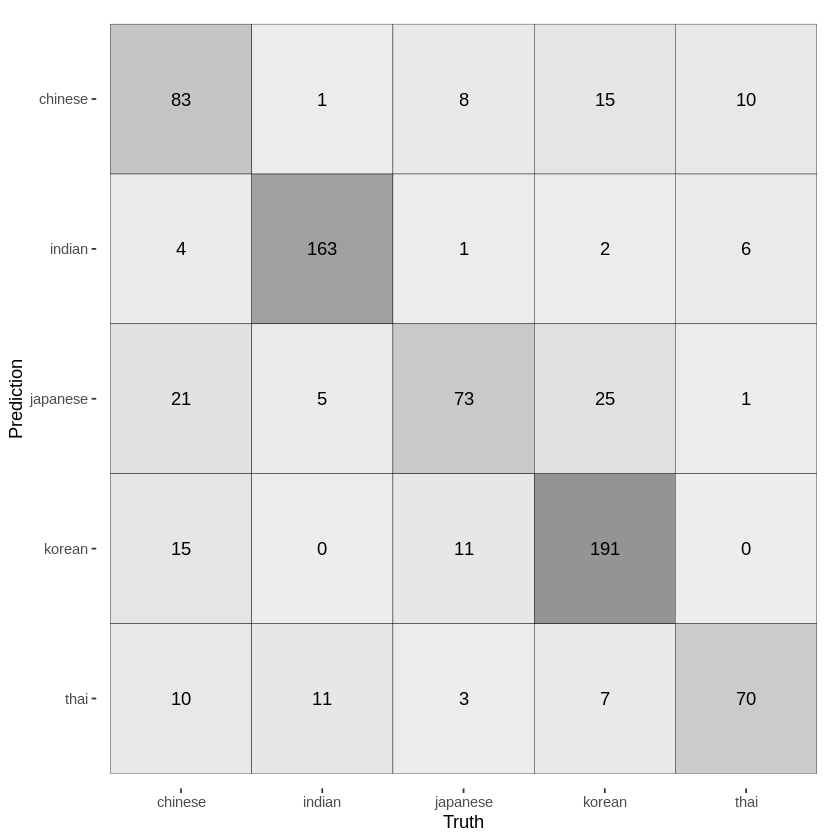

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Los cuadros más oscuros en el gráfico de la matriz de confusión indican un alto número de casos, y con suerte puedes observar una línea diagonal de cuadros más oscuros que indica los casos donde la etiqueta predicha y la real son las mismas.

Ahora calculemos las estadísticas resumidas para la matriz de confusión.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Si nos enfocamos en algunas métricas como precisión, sensibilidad, ppv, ¡no estamos tan mal para empezar 🥳!

## 4. Profundizando

Hagamos una pregunta sutil: ¿Qué criterio se utiliza para decidir un tipo de cocina como el resultado predicho?

Bueno, los algoritmos de aprendizaje automático estadístico, como la regresión logística, se basan en la `probabilidad`; por lo tanto, lo que realmente predice un clasificador es una distribución de probabilidad sobre un conjunto de posibles resultados. La clase con la probabilidad más alta se elige como el resultado más probable para las observaciones dadas.

Veamos esto en acción haciendo tanto predicciones de clase estrictas como probabilidades.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ ¿Puedes explicar por qué el modelo está bastante seguro de que la primera observación es tailandesa?

## **🚀Desafío**

En esta lección, utilizaste tus datos limpiados para construir un modelo de aprendizaje automático que puede predecir una cocina nacional basada en una serie de ingredientes. Tómate un tiempo para leer las [muchas opciones](https://www.tidymodels.org/find/parsnip/#models) que Tidymodels ofrece para clasificar datos y [otras formas](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) de ajustar regresión multinomial.

#### GRACIAS A:

[`Allison Horst`](https://twitter.com/allison_horst/) por crear las increíbles ilustraciones que hacen que R sea más acogedor y atractivo. Encuentra más ilustraciones en su [galería](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) y [Jen Looper](https://www.twitter.com/jenlooper) por crear la versión original en Python de este módulo ♥️

<br>
Hubiera incluido algunos chistes, pero no entiendo los juegos de palabras sobre comida 😅.

<br>

Feliz aprendizaje,

[Eric](https://twitter.com/ericntay), Embajador Estudiantil Gold de Microsoft Learn.



---

**Descargo de responsabilidad**:  
Este documento ha sido traducido utilizando el servicio de traducción automática [Co-op Translator](https://github.com/Azure/co-op-translator). Si bien nos esforzamos por lograr precisión, tenga en cuenta que las traducciones automáticas pueden contener errores o imprecisiones. El documento original en su idioma nativo debe considerarse como la fuente autorizada. Para información crítica, se recomienda una traducción profesional realizada por humanos. No nos hacemos responsables de malentendidos o interpretaciones erróneas que puedan surgir del uso de esta traducción.
